In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.io as sio
import scipy.optimize as opt

In [2]:
data = sio.loadmat('static/datasets/email/ex6data1.mat')

In [35]:
X, y = data['X'], data['y']

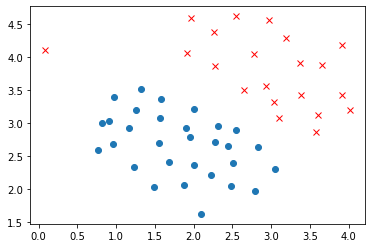

In [39]:
plot_data = np.concatenate((X, y), axis=1)
first_class = plot_data[plot_data[:,2] == 1]
second_class = plot_data[plot_data[:,2] == 0]
plt.plot(second_class[:, 0], second_class[:, 1], 'o')
plt.plot(first_class[:, 0], first_class[:, 1], 'x', color='red')

In [40]:
def svmTrain(X, Y, C, kernelFunction, tol=1e-3, max_passes=5, args=()):
    """
    Trains an SVM classifier using a  simplified version of the SMO algorithm.
    Parameters
    ---------
    X : numpy ndarray
        (m x n) Matrix of training examples. Each row is a training example, and the
        jth column holds the jth feature.
    Y : numpy ndarray
        (m, ) A vector (1-D numpy array) containing 1 for positive examples and 0 for negative examples.
    C : float
        The standard SVM regularization parameter.
    kernelFunction : func
        A function handle which computes the kernel. The function should accept two vectors as
        inputs, and returns a scalar as output.
    tol : float, optional
        Tolerance value used for determining equality of floating point numbers.
    max_passes : int, optional
        Controls the number of iterations over the dataset (without changes to alpha)
        before the algorithm quits.
    args : tuple
        Extra arguments required for the kernel function, such as the sigma parameter for a
        Gaussian kernel.
    Returns
    -------
    model :
        The trained SVM model.
    Notes
    -----
    This is a simplified version of the SMO algorithm for training SVMs. In practice, if
    you want to train an SVM classifier, we recommend using an optimized package such as:
    - LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
    - SVMLight (http://svmlight.joachims.org/)
    - scikit-learn (http://scikit-learn.org/stable/modules/svm.html) which contains python wrappers
    for the LIBSVM library.
    """
    # make sure data is signed int
    Y = Y.astype(int)
    # Dataset size parameters
    m, n = X.shape

    passes = 0
    E = np.zeros(m)
    alphas = np.zeros(m)
    b = 0

    # Map 0 to -1
    Y[Y == 0] = -1

    # Pre-compute the Kernel Matrix since our dataset is small
    # (in practice, optimized SVM packages that handle large datasets
    # gracefully will **not** do this)

    # We have implemented the optimized vectorized version of the Kernels here so
    # that the SVM training will run faster
    if kernelFunction.__name__ == 'linearKernel':
        # Vectorized computation for the linear kernel
        # This is equivalent to computing the kernel on every pair of examples
        K = np.dot(X, X.T)
    elif kernelFunction.__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X2 = np.sum(X**2, axis=1)
        K = X2 + X2[:, None] - 2 * np.dot(X, X.T)

        if len(args) > 0:
            K /= 2*args[0]**2

        K = np.exp(-K)
    else:
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i, j] = kernelFunction(X[i, :], X[j, :])
                K[j, i] = K[i, j]

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(m):
            E[i] = b + np.sum(alphas * Y * K[:, i]) - Y[i]

            if (Y[i]*E[i] < -tol and alphas[i] < C) or (Y[i]*E[i] > tol and alphas[i] > 0):
                # select the alpha_j randomly
                j = np.random.choice(list(range(i)) + list(range(i+1, m)), size=1)[0]

                E[j] = b + np.sum(alphas * Y * K[:, j]) - Y[j]

                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]

                if Y[i] == Y[j]:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                else:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]

                # objective function positive definite, there will be a minimum along the direction
                # of linear equality constrain, and eta will be greater than zero
                # we are actually computing -eta here (so we skip of eta >= 0)
                if eta >= 0:
                    continue

                alphas[j] -= Y[j] * (E[i] - E[j])/eta
                alphas[j] = max(L, min(H, alphas[j]))

                if abs(alphas[j] - alpha_j_old) < tol:
                    alphas[j] = alpha_j_old
                    continue
                alphas[i] += Y[i]*Y[j]*(alpha_j_old - alphas[j])

                b1 = b - E[i] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[i, j]

                b2 = b - E[j] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[j, j]

                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2)/2

                num_changed_alphas += 1
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    idx = alphas > 0
    model = {'X': X[idx, :],
             'y': Y[idx],
             'kernelFunction': kernelFunction,
             'b': b,
             'args': args,
             'alphas': alphas[idx],
             'w': np.dot(alphas * Y, X)}
    return model

In [41]:
def linearKernel(x1, x2):
    """
    Returns a linear kernel between x1 and x2.
    Parameters
    ----------
    x1 : numpy ndarray
        A 1-D vector.
    x2 : numpy ndarray
        A 1-D vector of same size as x1.
    Returns
    -------
    : float
        The scalar amplitude.
    """
    return np.dot(x1, x2)

In [50]:
def visualizeBoundaryLinear(X, y, model):
    """
    Plots a linear decision boundary learned by the SVM.
    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).
    y : array_like
        (m, ) The data labels.
    model : dict
        Dictionary of model variables learned by SVM.
    """
    w, b = model['w'], model['b']
    xp = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    yp = -(w[0] * xp + b)/w[1]

    plotData(X, y)
    pyplot.plot(xp, yp, '-b')

In [55]:
dir(linearKernel)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']